In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Qsharp
import qsharp

# Resource Estimation for varying input sizes.

In this notebook, we look at quantum resources required when the input size is varied. In particular, we look at the Number Partitioning Problem (NPP). When given an array of positive integers $A=\{a_1, a_2, a_3 ... a_n\}$ NPP is to find a partition $S$ such that difference between the sums of the $S$ and $S/A$ is minimum. For which the cost function $C$ can be defined as,

\begin{equation}
    C = (c-2\sum_{i=1}^{n}a_ix_i)^2.
\end{equation}

Where $c = \sum_{i=1}^n a_i$ sum of the array $A$ and $x_i$ is a binary variable indication if $a_i$ belongs to $S$ or not.  

## Unique partitions

For an array $A=\{a_1, a_2, a_3 ... a_n\}$ with $n$ elements the number of unique partitions is

\begin{equation}\tag{2}
    N_P = 2^{n-1}
\end{equation}

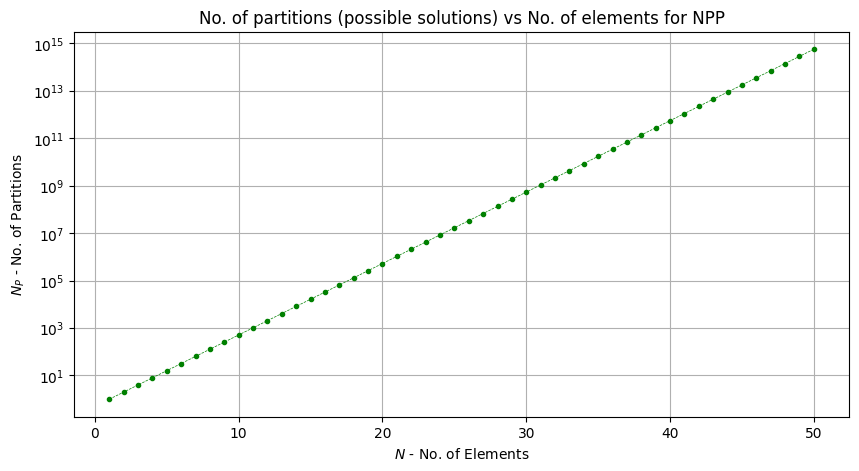

In [2]:
# Plotting number of partitions vs number of elements for NPP
input_size_plot = np.arange(1, 51, 1)
n_partitions = np.power(2,input_size_plot-1,dtype=np.int64)

plt.figure(figsize=(10, 5),dpi=100)
plt.plot(input_size_plot,n_partitions,c='g',ls='--',lw=0.5,marker='.')
plt.yscale('log')

plt.xlabel('$N$ - No. of Elements')
plt.ylabel('$N_P$ - No. of Partitions')

plt.grid()
plt.title("No. of partitions (possible solutions) vs No. of elements for NPP")

plt.show()

In [3]:
%%qsharp
// Q# snippet used to create and simulate the QAOA circuit.
namespace qaoa_note{

    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int{
        return n*i + j
    }
    // Cost Hamiltonian
    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit{

        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;

        // RZ Gates
        for qubit in 0..n_qubits-1{
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1{
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit])
        }
        // RZZ Gates
        for i in 0..n_qubits-1{
            for j in i+1..n_qubits-1{
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j])
            }
        }
    }

    // Mixer Hamiltonian
    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit{
        for qubit in qubits{
            Rx(2.0 * beta,qubit);
        }
    }

    // Function to create the QAOA circuit.
    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {

        use q = Qubit[NQubits];
        mutable integer_result = 0;

        // State Preparation |+>
        ApplyToEachA(H,q);

        for layer in 0..Layers-1{
            cost_unitary(q, gammas[layer], quadratics, linears);
            mixer_unitary(q, betas[layer]);
        }
        // Return the bitstring as an integer.
        return MeasureInteger(q);
    }
}

In [4]:
# Defining helper functions
def arr_to_str(a):
    """
    Converts a given array to a string representation.

    Args:
        a (list): The array to be converted.

    Returns:
        str: The string representation of the array.

    Example:
        >>> arr_to_str([1, 2, 3])
        '[1,2,3]'
    """
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string[:-1] + ']'

def generate_qsharp_string(n_qubits: int = 3,layers: int = 3) -> str:
    """Function to generate dummy input strings from no. of qubits and no. of layers"""

    # Preparing inputs for the Q# function.
    quadratics = np.array([1.1] * n_qubits**2)
    linears = np.array([1.2] * n_qubits)

    gammas = np.array([0.3] * layers)
    betas = np.array([0.4] * layers)

    input_str = f"{n_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears)}"
    qsharp_string = f"qaoa_note.circuit({input_str})"

    return qsharp_string

In [5]:
# Dictionary of all the resources we are tracking
resources = {"n_physical_qubits": ["physicalCounts","physicalQubits"],
            "circuit_runtime": ["physicalCounts","runtime"], # Runtime in nano-seconds
            "circuit_rqops": ["physicalCounts","rqops"], #Number of reliable quantum operations per second (rQOPS)
            "n_tstates": ["physicalCounts","breakdown","numTstates"],
            "required_logical_qubit_error": ["physicalCounts","breakdown","requiredLogicalQubitErrorRate"],
            "Code_distance": ["logicalQubit","codeDistance"],
            "Tfactory_percentage": ["physicalCountsFormatted","physicalQubitsForTfactoriesPercentage"],
            "total_Tfactory_qubits":["physicalCounts","breakdown","physicalQubitsForTfactories"],
            "n_Tfactory": ["physicalCounts","breakdown","numTfactories"],
            "Tfactory_qubits":["tfactory","physicalQubits"]}

In [6]:
test_params =[{
        "errorBudget": 0.09,
        "qubitParams": { "name": "qubit_gate_ns_e4" },
        "qecScheme": { "name": "surface_code" },
        "constraints": {"maxDuration":"3 s"}}
]

physical_qubits = []
runtime = []
rqops = []
n_tstates = []
required_error = []
code_distance = []
tfactory_percentage = []
total_tfactory_qubits = []
n_Tfactory = []
Tfactory_qubits =  []


for input_size in input_size_plot:
    input_str = generate_qsharp_string(input_size,1)
    result = qsharp.estimate(input_str,params = test_params)

    physical_qubits.append(result[resources["n_physical_qubits"][0]]
                           [resources["n_physical_qubits"][1]])
    runtime.append(result[resources["circuit_runtime"][0]]
                   [resources["circuit_runtime"][1]])
    rqops.append(result[resources["circuit_rqops"][0]]
                 [resources["circuit_rqops"][1]])
    n_tstates.append(result[resources["n_tstates"][0]]
                     [resources["n_tstates"][1]]
                     [resources["n_tstates"][2]])
    required_error.append(result[resources["required_logical_qubit_error"][0]]
                          [resources["required_logical_qubit_error"][1]]
                          [resources["required_logical_qubit_error"][2]])
    code_distance.append(result[resources["Code_distance"][0]]
                         [resources["Code_distance"][1]])
    tfactory_percentage.append(result[resources["Tfactory_percentage"][0]]
                         [resources["Tfactory_percentage"][1]])
    total_tfactory_qubits.append(result[resources["total_Tfactory_qubits"][0]]
                         [resources["total_Tfactory_qubits"][1]]
                         [resources["total_Tfactory_qubits"][2]])
    n_Tfactory.append(result[resources["n_Tfactory"][0]]
                      [resources["n_Tfactory"][1]]
                      [resources["n_Tfactory"][2]])
    Tfactory_qubits.append(result[resources["Tfactory_qubits"][0]]
                         [resources["Tfactory_qubits"][1]])

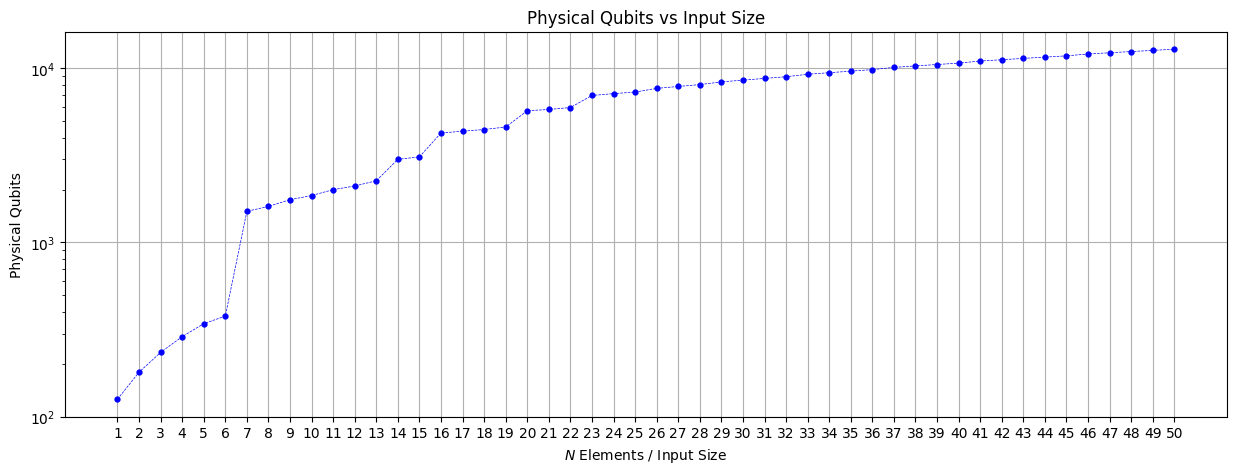

In [51]:
plt.figure(figsize=(15, 5),dpi=100)
plt.plot(input_size_plot,physical_qubits,c='blue',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')
plt.xticks(input_size_plot)

plt.xlabel('$N$ Elements / Input Size')
plt.ylabel('Physical Qubits')

plt.grid()
plt.title("Physical Qubits vs Input Size")

plt.show()

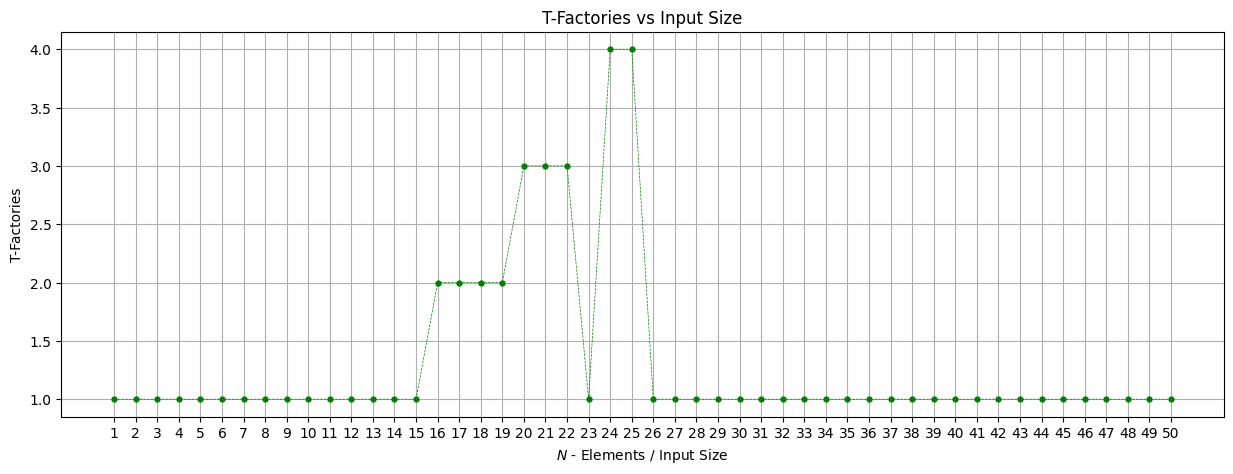

In [50]:
plt.figure(figsize=(15, 5),dpi=100)

plt.plot(input_size_plot,n_Tfactory,c='green',ls='--',lw=0.5,marker='.',ms=7)

plt.xticks(input_size_plot)

plt.xlabel('$N$ - Elements / Input Size')
plt.ylabel('T-Factories')

plt.grid()
plt.title("T-Factories vs Input Size")

plt.show()

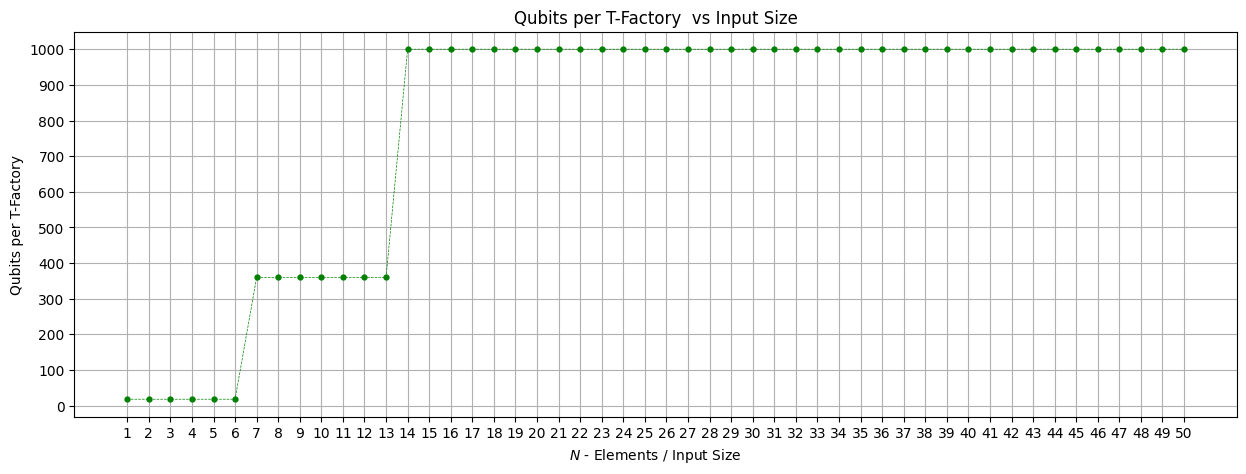

In [49]:
plt.figure(figsize=(15, 5),dpi=100)

plt.plot(input_size_plot,Tfactory_qubits,c='green',ls='--',lw=0.5,marker='.',ms=7)

plt.xticks(input_size_plot)
plt.yticks(np.arange(0, 1100, 100))

plt.xlabel('$N$ - Elements / Input Size')
plt.ylabel('Qubits per T-Factory')

plt.grid()
plt.title("Qubits per T-Factory  vs Input Size")

plt.show()

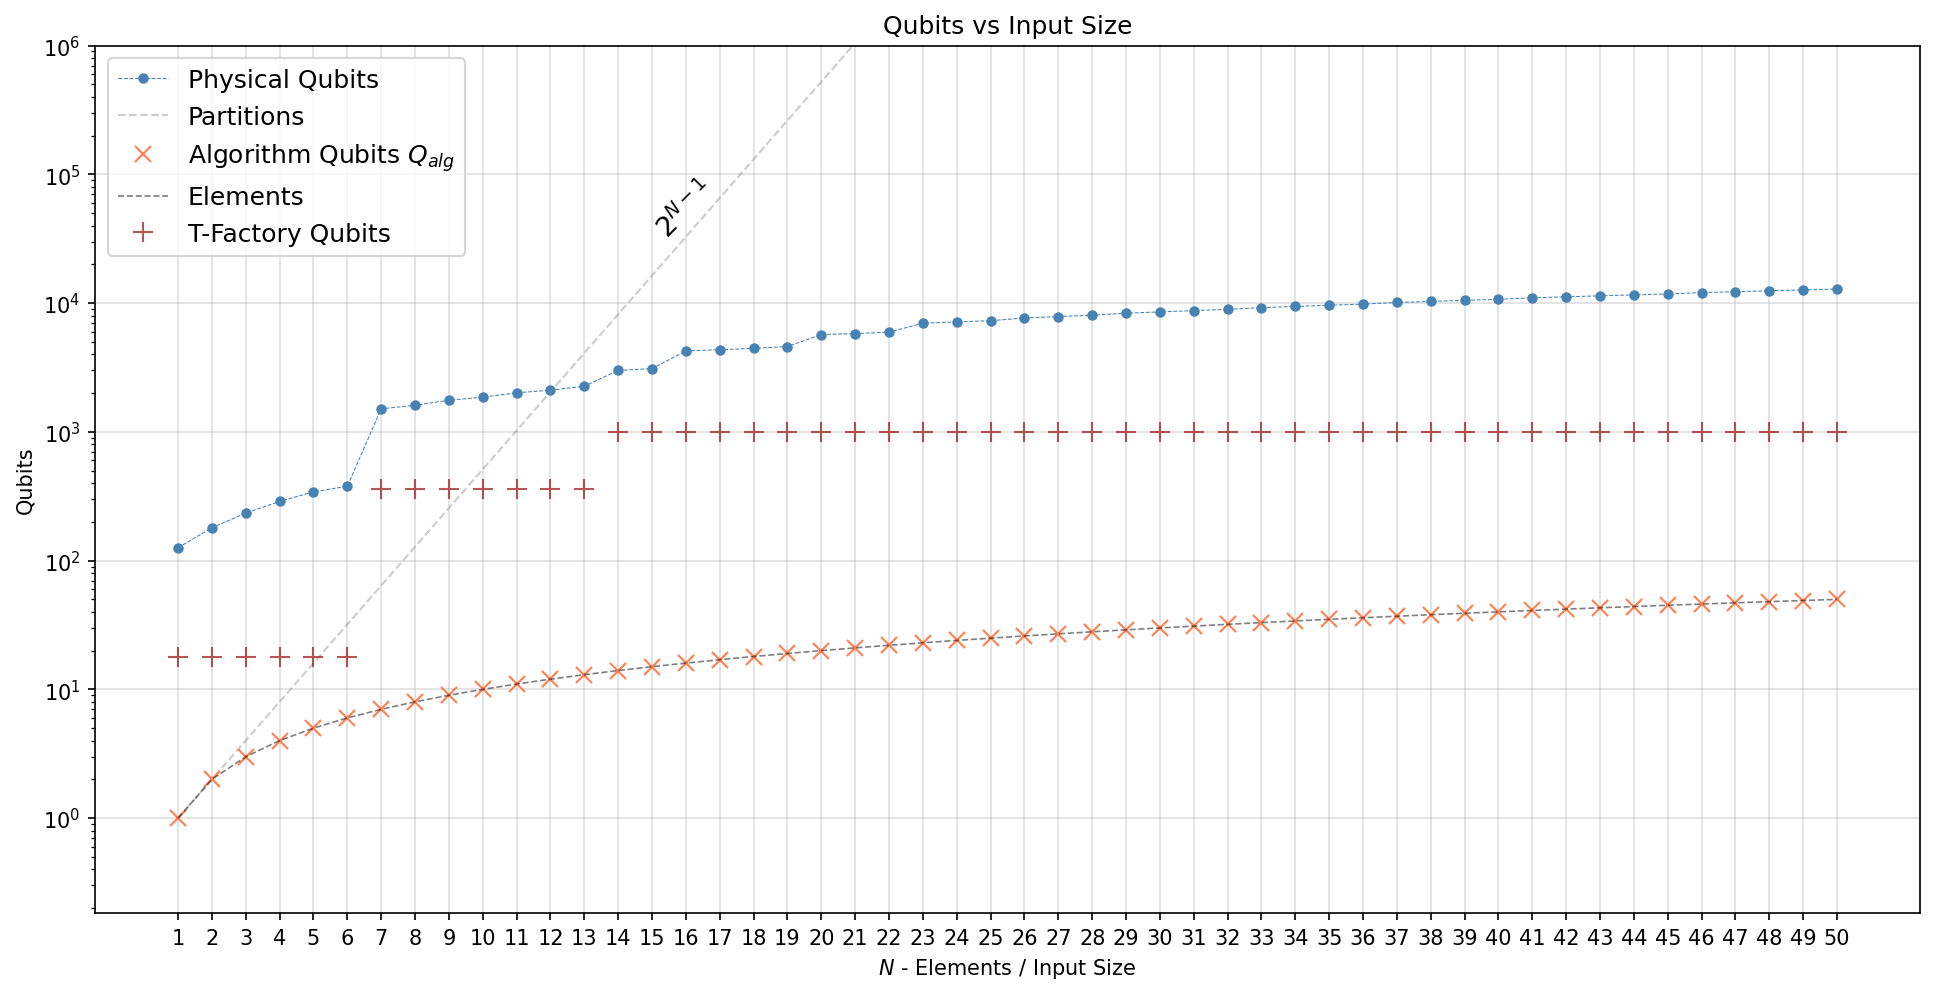

In [10]:
plt.figure(figsize=(13, 6.6),dpi=150)

# Physical Qubits
plt.plot(input_size_plot,physical_qubits,c='steelblue',ls='--',lw=0.5,marker='.',ms=8,label="Physical Qubits")

# Partitions
plt.plot(input_size_plot,n_partitions,c='gray',ls='--',lw=1,alpha=0.4,label="Partitions")

# Logical Qubits
plt.plot(input_size_plot,input_size_plot,c='coral',ls='',lw=1,marker='x',ms=8,label="Algorithm Qubits $Q_{alg}$")

# Elements
plt.plot(input_size_plot,input_size_plot,c='black',ls='--',lw=0.8,label="Elements",alpha=0.5)

# Physical T-factory Qubits
plt.plot(input_size_plot,Tfactory_qubits,c='brown',ls='',lw=0.5,marker='+',ms=10,label="T-Factory Qubits",alpha=0.8)

plt.yscale('log')
plt.xticks(input_size_plot)

plt.xlabel('$N$ - Elements / Input Size')
plt.ylabel('Qubits')

plt.ylim(top = 10e5)

plt.legend(loc="upper left",fontsize=12)
plt.grid(alpha=0.4)
plt.tight_layout()

plt.text(x=15,y=n_partitions[15],s='$2^{N-1}$',fontsize=13,rotation=45)

plt.title("Qubits vs Input Size")

plt.show()

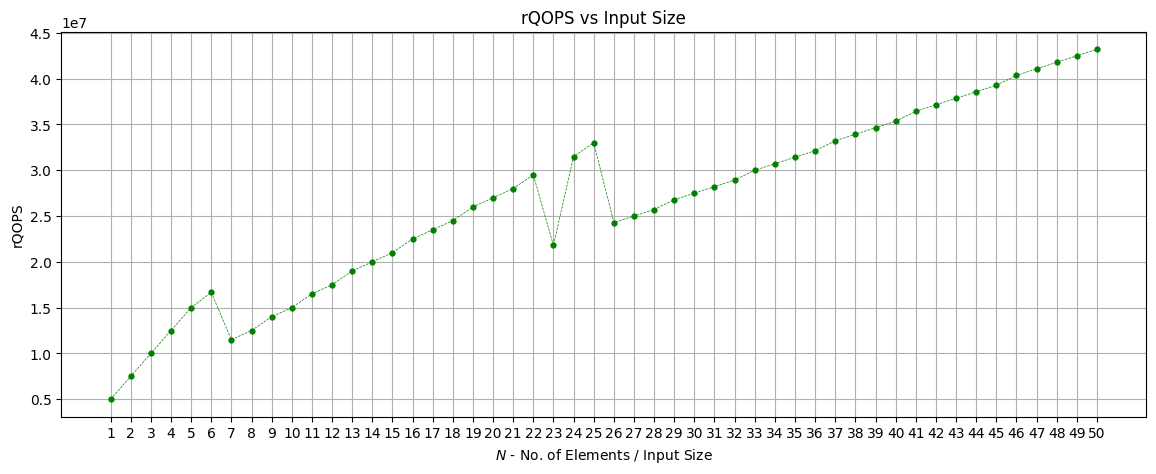

In [38]:
plt.figure(figsize=(14, 5),dpi=100)

plt.plot(input_size_plot,rqops,c='green',ls='--',lw=0.5,marker='.',ms=7)

plt.xticks(input_size_plot)

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('rQOPS')

plt.grid()
plt.title("rQOPS vs Input Size")

plt.show()

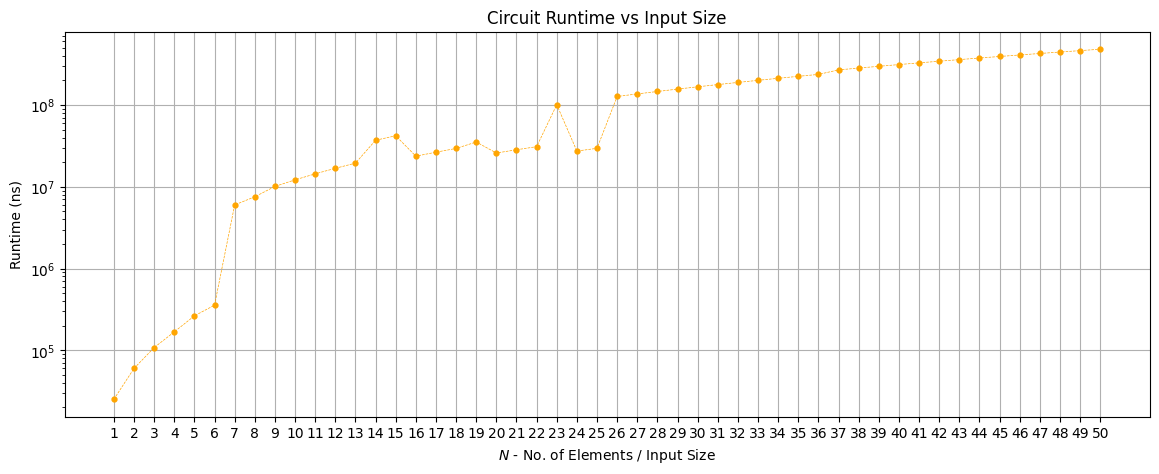

In [39]:
plt.figure(figsize=(14, 5),dpi=100)

plt.plot(input_size_plot,runtime,c='orange',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')

plt.xticks(input_size_plot)

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('Runtime (ns)')

plt.grid()
plt.title("Circuit Runtime vs Input Size")

plt.show()

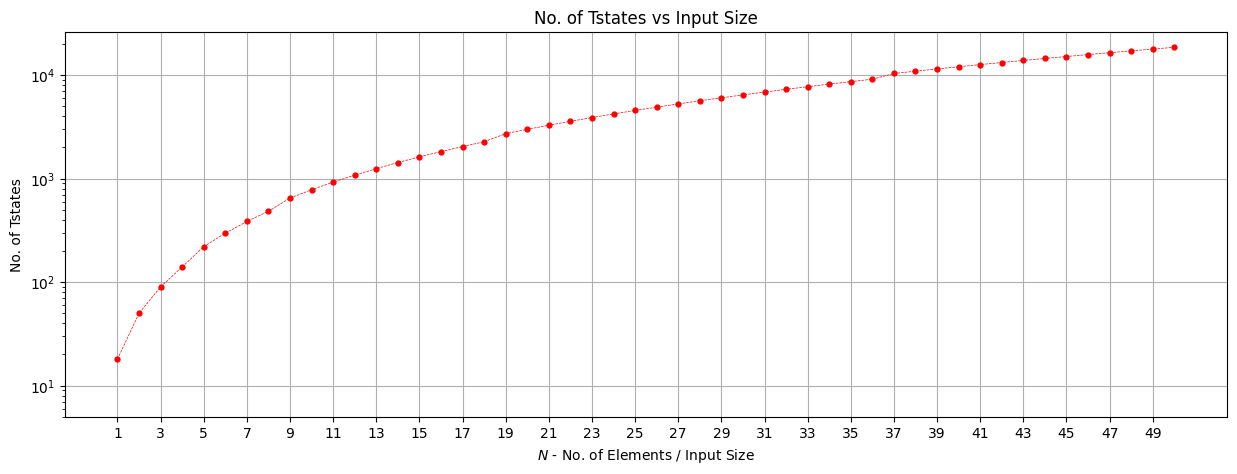

In [40]:
plt.figure(figsize=(15, 5),dpi=100)

plt.plot(input_size_plot,n_tstates,c='red',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('No. of Tstates')

plt.ylim(bottom = 5)

plt.xticks(input_size_plot[::2])

plt.grid()
plt.title("No. of Tstates vs Input Size")

plt.show()

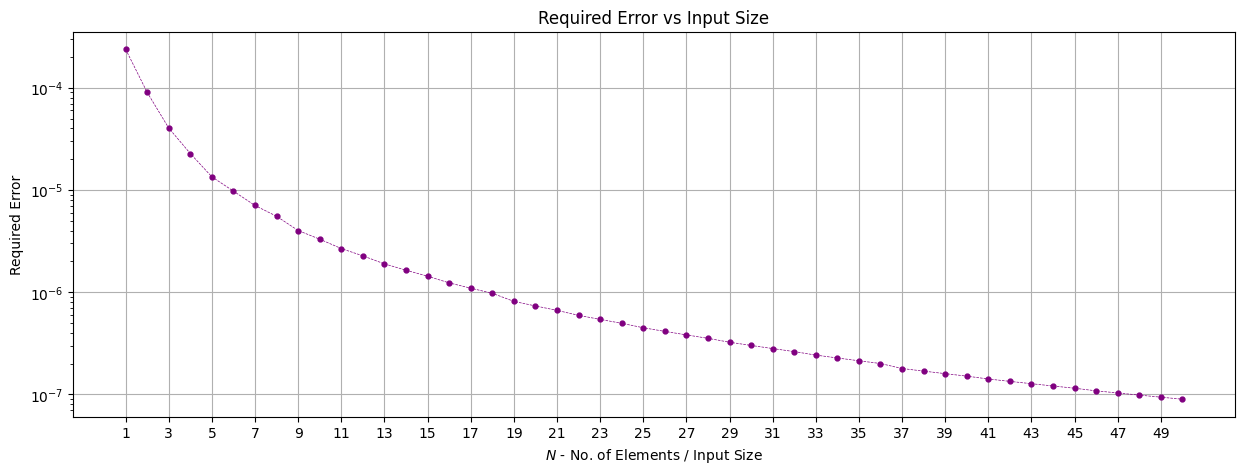

In [41]:
plt.figure(figsize=(15, 5),dpi=100)

plt.plot(input_size_plot,required_error,c='purple',ls='--',lw=0.5,marker='.',ms=7)

plt.yscale('log')

plt.xticks(input_size_plot[::2])

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('Required Error')

plt.grid()
plt.title('Required Error vs Input Size')

plt.show()

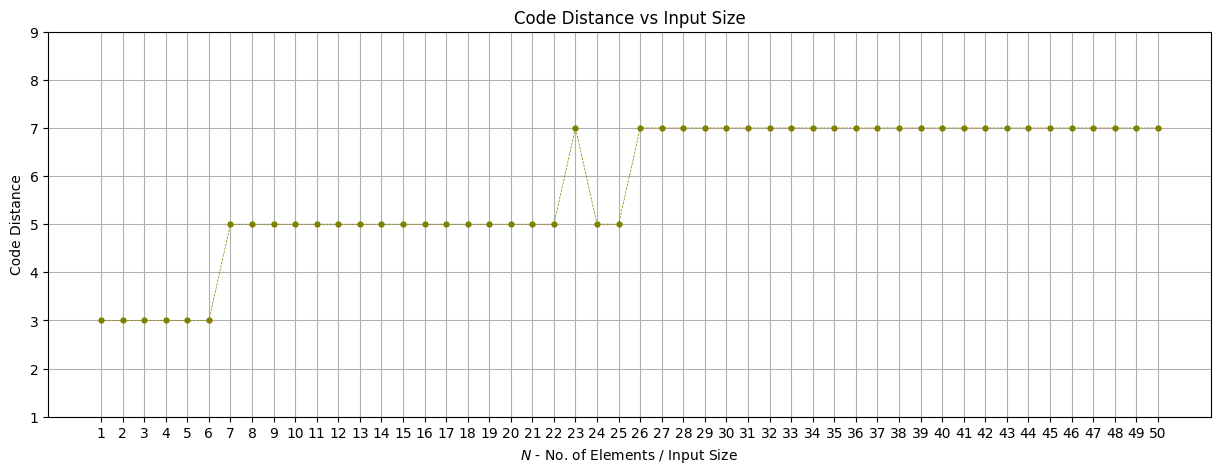

In [45]:
plt.figure(figsize=(15, 5),dpi=100)

plt.plot(input_size_plot,code_distance,c='olive',ls='--',lw=0.5,marker='.',ms=7)

plt.xlabel('$N$ - No. of Elements / Input Size')
plt.ylabel('Code Distance')

plt.yticks(np.arange(1, 10, step=1))
plt.xticks(input_size_plot)

plt.grid()
plt.title("Code Distance vs Input Size")

plt.show()

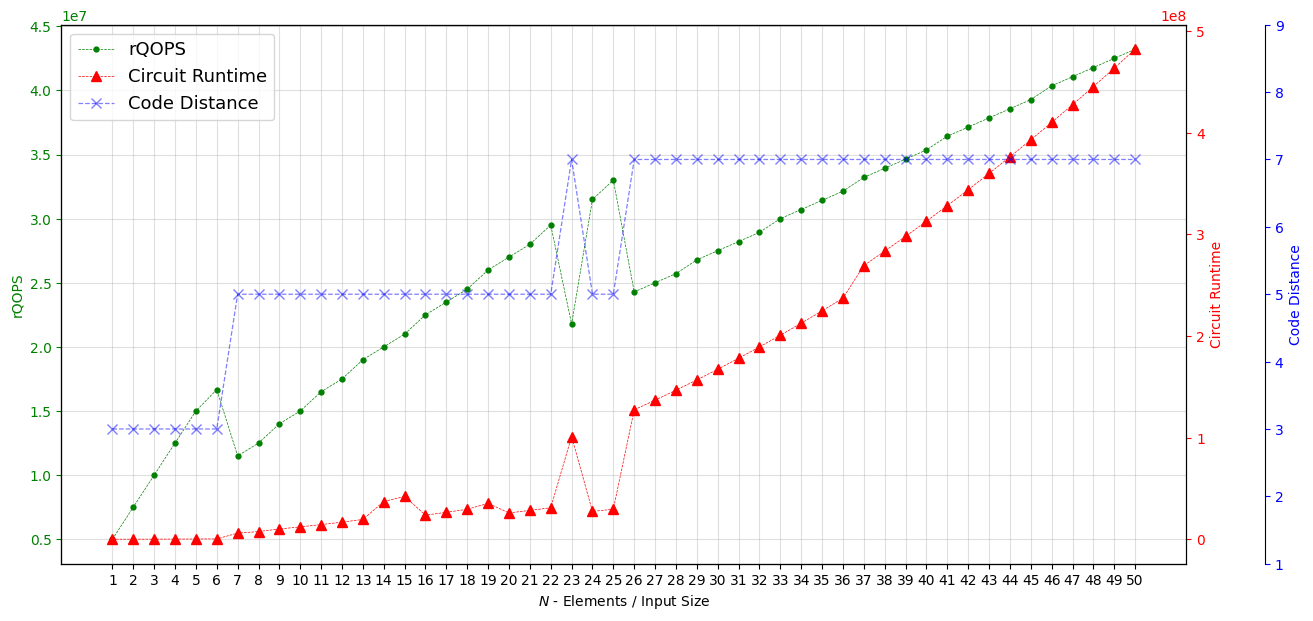

In [16]:
fig, ax = plt.subplots(figsize=(18, 7),dpi=100)
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()
twin2 = ax.twinx()

# Offset the right spine of twin2.  The ticks and label have already been
# placed on the right by twinx above.
twin2.spines.right.set_position(("axes", 1.07))

p1, = ax.plot(input_size_plot,rqops,c='green',ls='--',lw=0.5,marker='.',ms=7,label="rQOPS")
p2, = twin1.plot(input_size_plot,runtime,c='red',ls='--',lw=0.5,marker='^',ms=7,label="Circuit Runtime")
p3, = twin2.plot(input_size_plot,code_distance,c='blue',ls='--',lw=0.9,marker='x',ms=7,label="Code Distance",alpha=.5)


ax.set(xlabel="$N$ - Elements / Input Size", ylabel="rQOPS")
twin1.set(ylabel="Circuit Runtime")
twin2.set(ylabel="Code Distance",ylim=(1, 9))

ax.set_xticks(input_size_plot)

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())
twin2.yaxis.label.set_color(p3.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())
twin2.tick_params(axis='y', colors=p3.get_color())

ax.legend(handles=[p1, p2, p3],fontsize=13)
ax.grid(alpha=0.4)

plt.show()

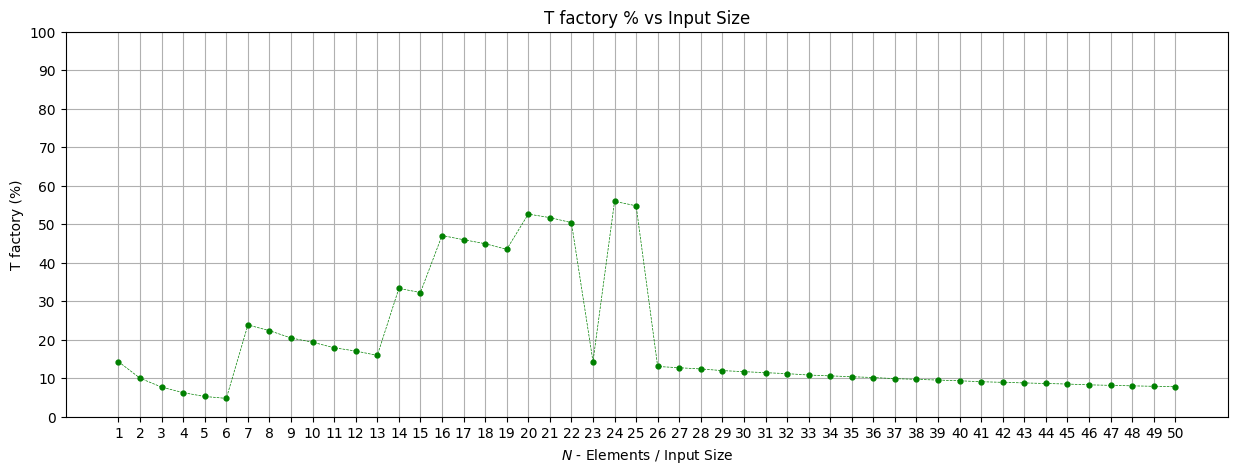

In [48]:
tfactory_percentage_arr = []
for i in tfactory_percentage:
    tfactory_percentage_arr.append(float(i[:-2]))

plt.figure(figsize=(15, 5),dpi=100)

plt.plot(input_size_plot,tfactory_percentage_arr,c='green',ls='--',lw=0.5,marker='.',ms=7)

plt.xlabel('$N$ - Elements / Input Size')
plt.ylabel('T factory (%)')

plt.ylim(0, 100)

plt.yticks(np.arange(0, 110, step=10))
plt.xticks(input_size_plot)

plt.grid()
plt.title("T factory % vs Input Size")

plt.show()

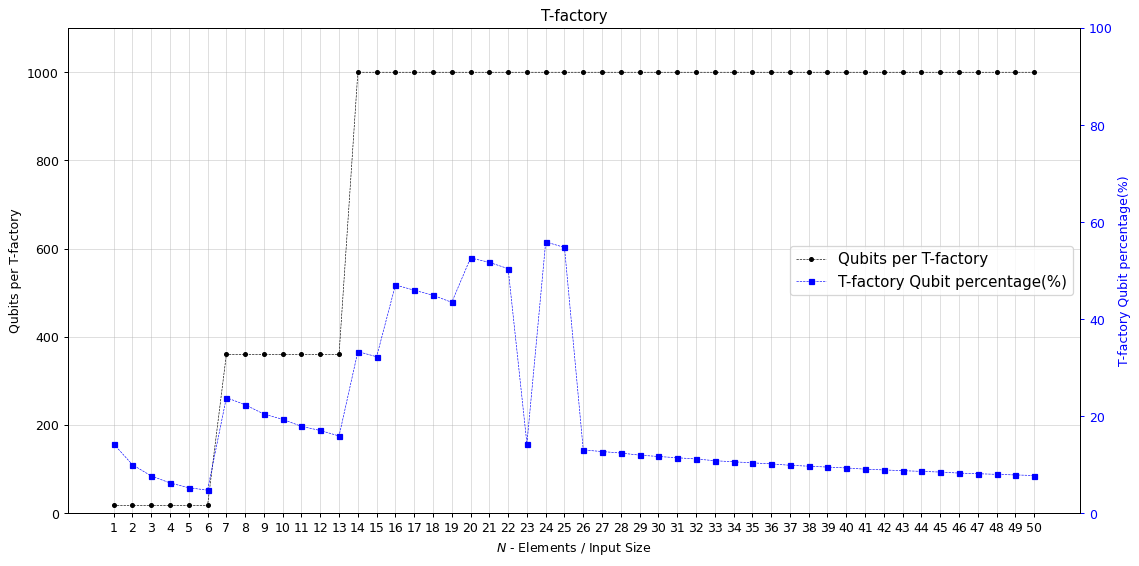

In [20]:
fig, ax = plt.subplots(figsize=(18, 7),dpi=90)
fig.subplots_adjust(right=0.75)

twin1 = ax.twinx()

p1, = ax.plot(input_size_plot,Tfactory_qubits,c='k',ls='--',lw=0.5,marker='.',ms=6,label="Qubits per T-factory")
p2, = twin1.plot(input_size_plot,tfactory_percentage_arr,c='blue',ls='--',lw=0.5,marker='s',ms=4,label="T-factory Qubit percentage(%)")


ax.set(xlabel="$N$ - Elements / Input Size", ylabel="Qubits per T-factory")
twin1.set(ylabel="T-factory Qubit percentage(%)")

ax.set_ylim(0, 1100)
twin1.set_ylim(0, 100)

ax.set_xticks(input_size_plot)

ax.yaxis.label.set_color(p1.get_color())
twin1.yaxis.label.set_color(p2.get_color())

ax.tick_params(axis='y', colors=p1.get_color())
twin1.tick_params(axis='y', colors=p2.get_color())

ax.legend(loc='right',handles=[p1, p2],fontsize=12)
ax.grid(alpha=0.4)

ax.set_title("T-factory")

plt.show()